In [1]:
# Preparing the Environment:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from zoomin.data.constants import (countries_dict, open_stack_list_NUTS3, open_stack_list_LAU, data_col_dic,
                                    data_col_dic_hist, data_columns, osm_network_length, osm_stations_quantity,
                                    freight_traffic_flow, vehicle_stock_DE, vehicle_stock_buildings_PL,
                                    economic_metric, socio_metric, demographic_metric, pixeles_quantity,
                                    industry_electricity_demand, industry_fuel_demand, industry_generation_capacity,
                                    industry_plants_quantity, environmental, railway_length, residential_energy_demand)
from zoomin.data.osmtags import networks_tags_dict, stations_tags_dict, name_tags_dict
import nbformat
from nbconvert.preprocessors import CellExecutionError, ExecutePreprocessor
from IPython.display import display, HTML

# Data Preparation and Scoring
from sklearn import preprocessing as pp
from scipy.stats import pearsonr
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold, GridSearchCV, RandomizedSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import reciprocal
from sklearn.metrics import make_scorer, accuracy_score, mean_absolute_error, mean_squared_error, r2_score
from matplotlib.colors import LogNorm

# ML Algorithms to be used
import tensorflow as tf
from tensorflow import keras
from keras import optimizers, models, layers, regularizers
from keras.optimizers import Nadam, Adam
from keras.models import Sequential
from keras.layers import Dense, Dropout, BatchNormalization, LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l1, l2
import xgboost as xgb
from xgboost import XGBRegressor
import hyperopt
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

<frozen importlib._bootstrap>:241: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Tensorflow configuration to use the GPU

In [2]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  # If there are GPUs available, print a message and enable memory growth
  print("GPU is available")
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
else:
  print("GPU is not available")

print(tf.config.list_physical_devices('GPU'))

GPU is available
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Pre-Processing
## Loading the data for EU

In [3]:
# Loading the data
cwd = os.getcwd()
DATA_PATH = os.path.join(cwd, '..', '..', '..', 'data', 'input')
RAW_DATA_PATH = os.path.join(DATA_PATH, 'raw')
PROCESSED_DATA_PATH = os.path.join(DATA_PATH, 'processed')
def read_Data():
        data_path = os.path.join(
        PROCESSED_DATA_PATH,
        'ancilliary_data',
        'processed'
        "data.csv")
        data_eu_raw = pd.read_csv(data_path)
        return data_eu_raw

data_eu_raw = read_Data()

## Filter Data for each country and creates its own csv file and saves it in the same directory

In [4]:
# define the directory where the data will be saved
output_dir = os.path.join(cwd, '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_raw')

# loop over the dictionary and filter the data and save it to the corresponding directory
for country, abbreviation in countries_dict.items():
    # filter the data based on the country abbreviation
    data_filtered = data_eu_raw[data_eu_raw["NUTS0_region_code"] == abbreviation]

    # create the directory for the country if it does not exist
    country_dir = os.path.join(output_dir, abbreviation)
    if not os.path.exists(country_dir):
        os.makedirs(country_dir)

    # save the filtered data to a CSV file in the country directory
    file_path_destination = os.path.join(country_dir, f"data_{abbreviation}_raw.csv")
    if not os.path.exists(file_path_destination):
        data_filtered.to_csv(file_path_destination, index=False)

## Loading data for specific country to use for testing

In [5]:
region = input('Please load data for specific country: EU, BE, EL, LT, PT, BG, ES, LU, RO, CZ, FR, HU, SI, DK, HR, MT, SK, DE, IT, NL, FI, EE, CY, AT, SE, IE, LV, PL')
def read_Data(region):
        data_path = os.path.join(cwd, '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_raw', f'{region}',  
        f"data_{region}_raw.csv")
        data_region_raw = pd.read_csv(data_path)
        return data_region_raw

data_region_raw = read_Data(region)

## CHeck Nan - Uniqueness - Distributions

#### Nan and fill

Drop columns with more than 100 Nan values and replace the remaining Nan values with the mean of each column

In [6]:
def check_nan_values_in_integers_float_columns_drop_and_replace_nan_with_mean(df):
    num_numeric_cols = 0
    num_dropped_cols = 0

    for col in df.columns:
        if df[col].dtype == 'float64' or df[col].dtype == 'float32' or df[col].dtype == 'int64' or df[col].dtype =='int32':
            num_numeric_cols += 1
            num_nans = df[col].isnull().sum()

            if num_nans > 0:
                print("The number of rows with NaN values in column", col, "is", num_nans)
                proportion_nans = num_nans / len(df[col])

                if proportion_nans > 0.1:
                    df.drop(col, axis=1, inplace=True)
                    num_dropped_cols += 1
                    print(f"Dropped column '{col}' due to more than 10% missing values.")
                else:
                    mean_val = df[col].mean()
                    df[col] = df[col].fillna(mean_val)
            else:
                print('The number of rows with NaN values in column', col, 'is', 0)
        else:
            print(f"Skipping non-numeric column '{col}'")

    percentage_dropped_cols = (num_dropped_cols / num_numeric_cols) * 100 if num_numeric_cols != 0 else 0

    print('----------------------------------------------------------------------------')
    print(df.select_dtypes(include=['float64', 'float32']).isnull().sum())
    print('----------------------------------------------------------------------------')

    print(f"\nTotal number of numeric columns: {num_numeric_cols}")
    print(f"Total number of dropped columns: {num_dropped_cols}")
    print(f"Percentage of dropped columns: {percentage_dropped_cols:.2f}%")

    return df

def convert_float_to_int(df):
    for column in df.columns:
        if df[column].dtype == 'float64' or df[column].dtype == 'float32':
            if not df[column].isnull().any():
                df[column] = df[column].astype(int)
    return df

def filter_rows_with_nan_in_string_cols(df):
    """
    Filter rows that contain NaN values in string/object columns of a pandas DataFrame.

    Parameters:
        df (pandas.DataFrame): The DataFrame to filter.

    Returns:
        pandas.DataFrame: The filtered DataFrame containing only unique rows with NaN values in string/object columns.
    """
    string_columns = df.select_dtypes(include=['object']).columns
    filtered_rows = pd.DataFrame()
    for col in string_columns:
        if df[col].isna().any():
            nan_rows = df[df[col].isna()]
            filtered_rows = pd.concat([filtered_rows, nan_rows]).drop_duplicates()

    return filtered_rows

##### EU

In [7]:
df_eu = check_nan_values_in_integers_float_columns_drop_and_replace_nan_with_mean(data_eu_raw)
df_eu = convert_float_to_int(df_eu)
filter_rows_with_nan_in_string_cols(df_eu)
df_eu['EU_region_code'] = df_eu['EU_region_code'].fillna('EU')
df_eu['NUTS0_region_code'] = df_eu['NUTS0_region_code'].fillna('EL')
df_eu['NUTS1_region_code'] = df_eu['NUTS1_region_code'].fillna('EL')
df_eu['NUTS2_region_code'] = df_eu['NUTS2_region_code'].fillna('EL')
filter_rows_with_nan_in_string_cols(df_eu)

Skipping non-numeric column 'EU_region_code'
Skipping non-numeric column 'NUTS0_region_code'
Skipping non-numeric column 'NUTS1_region_code'
Skipping non-numeric column 'NUTS2_region_code'
Skipping non-numeric column 'NUTS3_region_code'
The number of rows with NaN values in column deaths_value is 15
The number of rows with NaN values in column electricity demand of chemical industries_value is 0
The number of rows with NaN values in column electricity demand of iron and steel industries_value is 0
The number of rows with NaN values in column electricity demand of non-ferrous metal industries_value is 0
The number of rows with NaN values in column electricity demand of non-metallic mineral industries_value is 0
The number of rows with NaN values in column electricity demand of paper and printing industries_value is 0
The number of rows with NaN values in column electricity demand of refineries_value is 0
The number of rows with NaN values in column employment in nace sector G-I_value is

""


##### Country

In [8]:
df_country = check_nan_values_in_integers_float_columns_drop_and_replace_nan_with_mean(data_region_raw)
df_country = convert_float_to_int(df_country)
filter_rows_with_nan_in_string_cols(df_country)

Skipping non-numeric column 'EU_region_code'
Skipping non-numeric column 'NUTS0_region_code'
Skipping non-numeric column 'NUTS1_region_code'
Skipping non-numeric column 'NUTS2_region_code'
Skipping non-numeric column 'NUTS3_region_code'
The number of rows with NaN values in column deaths_value is 0
The number of rows with NaN values in column electricity demand of chemical industries_value is 0
The number of rows with NaN values in column electricity demand of iron and steel industries_value is 0
The number of rows with NaN values in column electricity demand of non-ferrous metal industries_value is 0
The number of rows with NaN values in column electricity demand of non-metallic mineral industries_value is 0
The number of rows with NaN values in column electricity demand of paper and printing industries_value is 0
The number of rows with NaN values in column electricity demand of refineries_value is 0
The number of rows with NaN values in column employment in nace sector G-I_value is 

""


### Exclude features with more than 50 % of zero values per country.

#### EU

In [9]:
def remove_high_zero_features(df, threshold=0.8):
    """
    Removes features with a high percentage of zero values and returns the remaining dataframe
    """
    num_features = len(df.columns[5:])
    zeros_percentage = (df == 0).mean()

    # Calculate percentage of features with specific percentages of zero values
    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of initial features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")

    # Remove features with high percentage of zero values
    to_remove = zeros_percentage[zeros_percentage >= threshold].index
    df = df.drop(to_remove, axis=1)
    num_features_after = len(df.columns[5:])

    print(f"Percentage of features removed due to high percentage of zeros: {100 * (1 - num_features_after/num_features):.2f}%")
    print(f"Number of remaining features: {num_features_after}")

    return df

df_eu = remove_high_zero_features(df_eu)

Number of initial features: 161
Percentage of columns with all zero values: 13.04%
Percentage of columns with at least 95% zero values: 31.68%
Percentage of columns with at least 90% zero values: 37.89%
Percentage of columns with at least 80% zero values: 49.07%
Percentage of columns with at least 70% zero values: 56.52%
Percentage of columns with at least 60% zero values: 60.87%
Percentage of columns with at least 50% zero values: 64.60%
Percentage of features removed due to high percentage of zeros: 49.07%
Number of remaining features: 82


#### Country

In [10]:
def remove_high_zero_features_country(df, threshold=0.8):
    """
    Removes features with a high percentage of zero values and returns the remaining dataframe
    """
    num_features = len(df.columns)
    zeros_percentage = (df == 0).mean()

    # Calculate percentage of features with specific percentages of zero values
    all_zero = round((zeros_percentage == 1).sum() / num_features * 100, 2)
    at_least_95 = round((zeros_percentage >= 0.95).sum() / num_features * 100, 2)
    at_least_90 = round((zeros_percentage >= 0.9).sum() / num_features * 100, 2)
    at_least_80 = round((zeros_percentage >= 0.8).sum() / num_features * 100, 2)
    at_least_70 = round((zeros_percentage >= 0.7).sum() / num_features * 100, 2)
    at_least_60 = round((zeros_percentage >= 0.6).sum() / num_features * 100, 2)
    at_least_50 = round((zeros_percentage >= 0.5).sum() / num_features * 100, 2)

    print(f"Number of initial features: {num_features}")
    print(f"Percentage of columns with all zero values: {all_zero:.2f}%")
    print(f"Percentage of columns with at least 95% zero values: {at_least_95:.2f}%")
    print(f"Percentage of columns with at least 90% zero values: {at_least_90:.2f}%")
    print(f"Percentage of columns with at least 80% zero values: {at_least_80:.2f}%")
    print(f"Percentage of columns with at least 70% zero values: {at_least_70:.2f}%")
    print(f"Percentage of columns with at least 60% zero values: {at_least_60:.2f}%")
    print(f"Percentage of columns with at least 50% zero values: {at_least_50:.2f}%")

    # Remove features with high percentage of zero values
    to_remove = zeros_percentage[zeros_percentage >= threshold].index
    df = df.drop(to_remove, axis=1)
    num_features_after = len(df.columns)

    print(f"Percentage of features removed due to high percentage of zeros: {100 * (1 - num_features_after/num_features):.2f}%")
    print(f"Number of remaining features: {num_features_after}")

    return df

df_country = remove_high_zero_features_country(df_country, threshold=0.2)

Number of initial features: 175
Percentage of columns with all zero values: 28.00%
Percentage of columns with at least 95% zero values: 46.86%
Percentage of columns with at least 90% zero values: 54.29%
Percentage of columns with at least 80% zero values: 58.86%
Percentage of columns with at least 70% zero values: 63.43%
Percentage of columns with at least 60% zero values: 63.43%
Percentage of columns with at least 50% zero values: 65.14%
Percentage of features removed due to high percentage of zeros: 70.86%
Number of remaining features: 51


## Sandardization

#### Plotting prior to Normalization

In [11]:
def scale_dataframe(df):
    df = df.iloc[:, 5:].astype(int).copy()
    scaler = StandardScaler().fit(df)
    X_scaled = scaler.transform(df)
    df_scaled = pd.DataFrame(X_scaled, columns=df.columns)
    return df_scaled

# Here a small number is added to the samples that are zero, this is so that when calculating the VIF the value is not infinite.
def add_small_value(df):
    # Find all zeros in the dataframe
    zero_inds = np.where(df == 0.0)

    # Add a small value (0.01) to each zero
    for i in range(len(zero_inds[0])):
        df.iloc[zero_inds[0][i], zero_inds[1][i]] = 0.01

    return df

df_scaled_eu = scale_dataframe(df_eu)
df_scaled_eu = add_small_value(df_scaled_eu)
df_scaled_country = scale_dataframe(df_country)
df_scaled_country = add_small_value(df_scaled_country)

## Feature Engineering

### Interaction features

##### EU

In [12]:
# df_scaled_eu.loc[:, 'deaths_per_person'] = df_scaled_eu['deaths_value'] / df_scaled_eu['population_value']
# df_scaled_eu.loc[:, 'fuel_stations_per_gdp'] = df_scaled_eu['fuel_stations_value'] / df_scaled_eu['gross domestic product_value']
# df_scaled_eu.loc[:, 'total area_value_times_population_value'] = df_scaled_eu['total area_value'] * df_scaled_eu['population_value']
# df_scaled_eu.drop([
    # 'deaths_value',
    # 'fuel_stations_value',
        # 'total area_value'
            # ], axis=1, inplace=True)

##### Country

In [13]:
# df_scaled_country.loc[:, 'deaths_per_person'] = df_scaled_country['deaths_value'] / df_scaled_country['population_value']
# df_scaled_country.loc[:, 'fuel_stations_per_gdp'] = df_scaled_country['fuel_stations_value'] / df_scaled_country['gross domestic product_value']
# df_scaled_country.loc[:, 'total area_value_times_population_value'] = df_scaled_country['total area_value'] * df_scaled_country['population_value']
# df_scaled_country.drop([
    # 'deaths_value',
    # 'fuel_stations_value',
        # 'total area_value'
            # ], axis=1, inplace=True)

## Variance Inflation Factor (VIF)

##### EU

In [14]:
def calculate_vif_initial(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             'vif_df_sorted_eu_data_initial.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]

    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})

    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    return vif_df_sorted

vif_df_sorted_eu = calculate_vif_initial(df_scaled_eu)

def select_features_vif(new_df, vif_df_sorted):
    # Select variables with VIF less than 10
    vif_df_subset = vif_df_sorted[vif_df_sorted['VIF'] < 10]

    # Manually select additional features
    selected_features = [
        'charging_stations_value',
        'deaths_value',
        # 'deaths_per_person',
        'total area_value',
        # 'total area_value_times_population_value',
        'fuel_stations_value',
        # 'fuel_stations_per_gdp',
        'population_value',
        'gross domestic product_value',
        'Traffic_flow_tons_2019',
        'total employment_value',
        'live births_value',
    # 'population_value', 'charging_stations_value', 'deaths_per_person', 'fuel_stations_per_gdp', 'total area_value_times_population_value'
    ]

    # Combine the two lists of features and drop any duplicates
    all_features = list(set(list(vif_df_subset['Variable']) + selected_features))

    # Remove additional columns
    remove_features = [
        'relative gross value added_value',
        # 'total area_value'
        ]
    all_features = [feature for feature in all_features if feature not in remove_features]

    # Create a new dataframe with only the selected features
    df_selected = new_df[all_features]

    return df_selected

df_selected_eu = select_features_vif(df_scaled_eu, vif_df_sorted_eu)

def calculate_vif_final(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             'vif_df_sorted_eu_data_final.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]

    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})

    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    return vif_df_sorted

vif_df_eu = calculate_vif_final(df_selected_eu)

##### Country

In [15]:
def calculate_vif_initial(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             f'vif_df_sorted_{region}_data_initial.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]

    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})

    # Remove rows with infinite VIF values
    vif_df = vif_df.replace([np.inf, -np.inf], np.nan).dropna()

    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)

    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)

    return vif_df_sorted

vif_df_sorted_country = calculate_vif_initial(df_scaled_country)

def select_features_vif(new_df, vif_df_sorted):
    # Select variables with VIF less than 10
    vif_df_subset = vif_df_sorted[vif_df_sorted['VIF'] < 10000000000000000]

    # Manually select additional features
    selected_features = [
        'charging_stations_value',
        'population_value',
        'gross domestic product_value',
        # 'Traffic_flow_tons_2019',
        'total employment_value',
        'live births_value',
        'deaths_value',
        # 'deaths_per_person',
        'total area_value',
        # 'total area_value_times_population_value',
        'fuel_stations_value',
        # 'fuel_stations_per_gdp',
        # 'Buses',
        'gross value added_value'
    # 'population_value', 'charging_stations_value', 'deaths_per_person', 'fuel_stations_per_gdp', 'total area_value_times_population_value',
    ]
    # Combine the two lists of features and drop any duplicates
    all_features = list(set(list(vif_df_subset['Variable']) + selected_features))

    # Remove additional columns
    remove_features = [
    ]
    all_features = [feature for feature in all_features if feature not in remove_features]

    # Create a new dataframe with only the selected features
    df_selected = new_df[all_features]

    return df_selected

df_selected_country = select_features_vif(df_scaled_country, vif_df_sorted_country)

def calculate_vif_final(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             f'vif_df_sorted_{region}_data_final.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]

    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})

    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    return vif_df_sorted

vif_df_country = calculate_vif_final(df_selected_country)

c:\Users\rofer\anaconda3\envs\Thesis\lib\site-packages\statsmodels\stats\outliers_influence.py:195: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


#### Keep the intersection of the columns of the training and test data

In [16]:
def keep_intersected_columns(df1, df2):
    intersected_columns = list(set(df1.columns).intersection(set(df2.columns)))
    df1_intersected = df1[intersected_columns]
    df2_intersected = df2[intersected_columns]
    return df1_intersected, df2_intersected

df_inter_country, df_inter_eu = keep_intersected_columns(df_selected_country, df_selected_eu)

def calculate_vif_intersected(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             'vif_df_sorted_eu_data_intersected_final.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]

    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})

    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    return vif_df_sorted

vif_df_eu_intersected = calculate_vif_intersected(df_inter_eu)

def calculate_vif_intersected_country(df_scaled):
    file_path_destination = os.path.join(cwd, '..', '..', '..', 'data', 'output',
                                             'spatial_disaggregation',
                                             'data_visualization',
                                             'Variance_inflation_factor',
                                             'vif_df_sorted_country_data_intersected_final.csv')
    # Calculate VIF values
    vif = [variance_inflation_factor(df_scaled.values, i) for i in range(df_scaled.shape[1])]

    # Create a dataframe with column names and VIF values
    vif_df = pd.DataFrame({'Variable': df_scaled.columns, 'VIF': vif})

    # Sort the dataframe in descending order by VIF values
    vif_df_sorted = vif_df.sort_values('VIF', ascending=False)
    # Save data to file if it doesn't exist
    # vif_df_sorted.to_csv(file_path_destination, index=False)
    return vif_df_sorted

vif_df_country_intersected = calculate_vif_intersected_country(df_inter_country)

In [17]:
vif_df_eu_intersected.head(50)

,Variable,VIF
11,population_value,72.941400
16,total employment_value,35.099411
8,deaths_value,26.670377
1,live births_value,25.494177
0,gross domestic product_value,11.328780
9,fuel_stations_value,9.162928
18,total area_value,5.528691
15,number of pixels with transitional woodland-sh...,5.395348
7,railway_station_value,4.355773
20,bus_stations_value,4.260386


# Master Dataframe Preparation

In [18]:
def create_master_dataframe_based_on_population_weights(df, df_NUTS_columns, feature_names, agg_var_to_disagg, region, predicted_values=None):

    # Check if there is a column named 'index' and drop it if necessary
    if 'index' in df.columns:
        df = df.drop(columns='index')

    # Append the "region_columns" dataframe to the main features dataframe
    first_five_columns_df = df_NUTS_columns.iloc[:, :5].copy()
    df = pd.concat([first_five_columns_df, df], axis=1)

    # Extract the "aggregated_metric" column as a new dataframe
    aggregated_metric = df.loc[:, f"{agg_var_to_disagg}"].copy()
    aggregated_metric_df = pd.concat([first_five_columns_df, pd.DataFrame(aggregated_metric)], axis=1)

    # Extract the "aggregated_metric_df" column as two new dataframes: The real variable at NUTS3 level. Target to disaggregate.
    df_eu_apply_target = aggregated_metric_df.copy()
    df_eu_apply_target = df_eu_apply_target.rename(columns={df_eu_apply_target.columns[5]: 'target_variable'})
    # Add the index as a column to the EU target DataFrame
    df_eu_apply_target['index'] = df_eu_apply_target.index
    df_region_apply_target = df_eu_apply_target.loc[df_eu_apply_target ['NUTS0_region_code'] == region, :].copy()

    # Remove the "aggregated_metric" column from the main dataframe
    df = df.drop(columns=[f"{agg_var_to_disagg}"])

    # Remove "aggregated_metric" from the feature_names list
    print('The length of all ancilliary features + the aggregated feature is: ', len(feature_names))
    feature_names = [f for f in feature_names if f != f"{agg_var_to_disagg}"]
    print('The length of all ancilliary features is: ', len(feature_names))

    # Compute the population weights
    pd.set_option('display.float_format', lambda x: '%.4f' % x)
    metric_weight_df = df.iloc[:, :5].copy()  # select first 5 columns and make a copy
    metric_weight_df['population_weight'] = df.groupby('NUTS0_region_code', group_keys=False)['population_value'].apply(lambda x: x / x.sum().round(4)).reset_index(drop=True)

    # Compute the sum of the agg_var_to_disagg at country level (variable that want to be disaggregated)
    agg_metric_country_value = aggregated_metric_df.groupby('NUTS0_region_code').agg({f'{agg_var_to_disagg}': 'sum'}).reset_index(drop=False)
    # Calculate the pseudo value multiplying the population weight of each NUTS3_region by the agg_var_to_disagg for each country (each NUTS3_region_code weight by each NUTS0_region_code aggregate population)
    agg_metric_pseudo_value = metric_weight_df.merge(agg_metric_country_value, on=['NUTS0_region_code'], how='left')[[f'{agg_var_to_disagg}', 'population_weight']].prod(axis=1).groupby(level=0).sum()
    agg_metric_pseudo_value = pd.DataFrame(agg_metric_pseudo_value, columns=[f"{agg_var_to_disagg}"])

    # Extract the metric disaggregated at NUTS3 level from the pseudo value from population_weight as the first initial disaggregated method
    disagg_metric_population_all = pd.concat([first_five_columns_df, agg_metric_pseudo_value], axis=1).copy()
    disagg_metric_population_all = disagg_metric_population_all.rename(columns={disagg_metric_population_all.columns[5]: 'target_variable'})
    disagg_metric_population_all['index'] = disagg_metric_population_all.index

    # Filter the disagg_metric_population_all DataFrame to get the disaggregated metric for the specified region
    disagg_metric_population = disagg_metric_population_all[disagg_metric_population_all['NUTS0_region_code'].str.startswith(f'{region}')].copy()

    # Extract the disaggregated metric for the entire EU
    disagg_metric_population_eu = disagg_metric_population_all.copy()

    # Combine all the dataframes to start the creation of the master dataframe
    df_apply_eu = pd.concat([first_five_columns_df, df[feature_names], agg_metric_pseudo_value], axis=1)
    # Add the index as a column to the EU target DataFrame
    df_apply_eu['index'] = df_apply_eu.index
    # Filter the master_df to only include NUTS_0 regions that start with 'DE'
    df_apply_region = df_apply_eu[df_apply_eu['NUTS0_region_code'].str.startswith(f'{region}')].copy()

    # Create a DataFrame to store the master input and target data
    master_input_df = pd.DataFrame()
    master_label_df = pd.DataFrame()

    # Loop through each feature
    for feature in feature_names:
        # Compute the sum of the feature for each NUTS0 region (country level)
        agg_country_value = df.groupby('NUTS0_region_code').agg({f'{feature}': 'sum'}).reset_index(drop=False)

        # Calculate the pseudo value multiplying the population weight of each NUTS3_region by the agg_var_to_disagg for each country (each NUTS3_region_code weight by each NUTS0_region_code aggregate feature)
        pseudo_value = metric_weight_df.merge(agg_country_value, on=['NUTS0_region_code'], how='left')[[f'{feature}', 'population_weight']].prod(axis=1).groupby(level=0).sum()

        # Create a DataFrame with the target variable (variable to predict. The true value of the pseudo_value)
        y = df[f'{feature}'].reset_index(drop=True)

        # Create a copy of the df DataFrame to store the pseudo-value for this feature
        df_pseudo = df.copy()

        # Replace the feature column in df_pseudo with the new feature_df
        feature_df = pd.DataFrame(data=pseudo_value.values, index=pseudo_value.index, columns=[f'{feature}_pseudo'])
        df_pseudo[f'{feature}'] = feature_df[f'{feature}_pseudo']

        # Append the DataFrame to the master DataFrame
        master_input_df = pd.concat([master_input_df, df_pseudo], axis=0, ignore_index=True)
        master_label_df = pd.concat([master_label_df, y], axis=0, ignore_index=True)

    # Append the "agg_metric_pseudo_value" dataframe as many times as necessary
    master_input_df = pd.concat([master_input_df, pd.concat([agg_metric_pseudo_value]*len(feature_names), axis=0, ignore_index=True)], axis=1)

    # Append the "region_columns" dataframe as many times as necessary to the "y" labeled column
    master_label_df = pd.concat([pd.concat([first_five_columns_df]*len(feature_names), axis=0, ignore_index=True), master_label_df], axis=1)

    # Add the index as a column to the master DataFrame
    master_input_df['index'] = master_input_df.index
    master_label_df = master_label_df.rename(columns={master_label_df.columns[5]: 'target_variable'})
    master_label_df['index'] = master_label_df.index

    # Splitting the master DataFrame into train and test data (Splitting the data into EU and the country to test on)
    master_input_train_df = master_input_df.loc[master_input_df['NUTS0_region_code'] != region, :].copy()
    master_label_train_df = master_label_df.loc[master_label_df['NUTS0_region_code'] != region, :].copy()
    master_input_test_df = master_input_df.loc[master_input_df['NUTS0_region_code'] == region, :].copy()
    master_label_test_df = master_label_df.loc[master_label_df['NUTS0_region_code'] == region, :].copy()

    # If predicted_values are provided, update the relevant DataFrames
    if predicted_values is not None:
        # Calculate the repeat factor
        repeat_factor = len(master_input_df) // len(predicted_values)

        # Repeat predicted_values by the repeat factor along the y-axis
        repeated_predicted_values = pd.concat([predicted_values] * repeat_factor, axis=0, ignore_index=True)

        # Update master_input_df with repeated_predicted_values
        master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
        # master_input_df.loc[:, agg_var_to_disagg] = repeated_predicted_values.values

        # Update master_input_train_df and master_input_test_df with repeated_predicted_values
        master_input_train_df = master_input_df.loc[master_input_df['NUTS0_region_code'] != region, :].copy()
        master_input_test_df = master_input_df.loc[master_input_df['NUTS0_region_code'] == region, :].copy()

        # Update df_apply_eu with repeated_predicted_values
        df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
        # df_apply_eu.loc[:, agg_var_to_disagg] = repeated_predicted_values.values

        # Update df_apply_region with repeated_predicted_values
        df_apply_region = df_apply_eu[df_apply_eu['NUTS0_region_code'].str.startswith(f'{region}')].copy()

    return master_input_df, master_label_df, master_input_train_df, master_label_train_df, master_input_test_df, master_label_test_df, \
        df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
            disagg_metric_population, disagg_metric_population_eu

column_list_eu = []
# assuming your DataFrame is called 'df'
for col in df_inter_eu.columns:
    column_list_eu.append(col)

In [19]:
column_list_eu

['gross domestic product_value',
 'live births_value',
 'train_station_value',
 'number of pixels with sport and leisure facilities_value',
 'charging_stations_value',
 'Traffic_flow_tons_2019',
 'number of pixels with non-irrigated arable land_value',
 'railway_station_value',
 'deaths_value',
 'fuel_stations_value',
 'helicopter_station_value',
 'population_value',
 'railway length (with power source - non-electrified)_value',
 'number of pixels with broad-leaved forest_value',
 'railway length (with power source - overhead electrified)_value',
 'number of pixels with transitional woodland-shrub_value',
 'total employment_value',
 'number of pixels with mixed forest_value',
 'total area_value',
 'number of pixels with pastures_value',
 'bus_stations_value',
 'number of pixels with continuous urban fabric_value',
 'airport_stations_value']

# Dataset for the model

In [20]:
def prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu):
    # Select only numeric columns for train and test data
    numeric_cols_1 = master_input_train_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_2 = master_input_test_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    X_train = master_input_train_df[numeric_cols_1].copy()
    X_test = master_input_test_df[numeric_cols_2].copy()

    # Select only numeric columns for label train and test data
    numeric_cols_3 = master_label_train_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_4 = master_label_test_df.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_train = master_label_train_df[numeric_cols_3].copy()
    y_test = master_label_test_df[numeric_cols_4].copy()

    # Select only numeric columns for apply EU and apply region data
    numeric_cols_5 = df_apply_eu.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_6 = df_apply_region.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    X_train_apply = df_apply_eu[numeric_cols_5].copy()
    X_test_apply = df_apply_region[numeric_cols_6].copy()

    # Select only numeric columns for apply EU and apply region data
    numeric_cols_7 = df_eu_apply_target.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    numeric_cols_8 = df_region_apply_target.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_train_apply = df_eu_apply_target[numeric_cols_7].copy()
    y_test_apply = df_region_apply_target[numeric_cols_8].copy()

    # Select only numeric columns for the first disaggregation metric with population
    numeric_cols_9 = disagg_metric_population.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_predict_pop = disagg_metric_population[numeric_cols_9].copy()

    # Select only numeric columns for the first disaggregation metric with population
    numeric_cols_10 = disagg_metric_population_eu.select_dtypes(include=['int32', 'int64', 'float64', 'float32']).columns
    y_predict_pop_eu = disagg_metric_population_eu[numeric_cols_10].copy()

    # Select target variable for label train and test data
    y_train = y_train['target_variable']
    y_test = y_test['target_variable']
    y_train_apply = y_train_apply['target_variable']
    y_test_apply = y_test_apply['target_variable']

    return X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu

def save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, y_predict_pop_eu, country_code, agg_var_to_disagg):
    # Set the directory to save the dataframes
    output_dir = os.path.join(os.getcwd(), '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_train_test', country_code)

    # Create the directory if it doesn't exist
    if not os.path.exists(output_dir):
        os.makedirs(output_dir)

    # Set the file paths for the dataframes
    file_paths = [
        (X_train, f'X_train_{agg_var_to_disagg}_{country_code}.csv'),
        (X_test, f'X_test_{agg_var_to_disagg}_{country_code}.csv'),
        (y_train, f'y_train_{agg_var_to_disagg}_{country_code}.csv'),
        (y_test, f'y_test_{agg_var_to_disagg}_{country_code}.csv'),
        (X_train_apply, f'X_train_apply_{agg_var_to_disagg}_{country_code}.csv'),
        (X_test_apply, f'X_test_apply_{agg_var_to_disagg}_{country_code}.csv'),
        (y_train_apply, f'y_train_apply_{agg_var_to_disagg}_{country_code}.csv'),
        (y_test_apply, f'y_test_apply_{agg_var_to_disagg}_{country_code}.csv'),
        (y_predict_pop, f'y_predict_pop_{agg_var_to_disagg}_{country_code}.csv'),
        (y_predict_pop_eu, f'y_predict_pop_eu{agg_var_to_disagg}_{country_code}.csv')
    ]

    # Save each dataframe to a CSV file
    for df, filename in file_paths:
        filepath = os.path.join(output_dir, filename)
        df.to_csv(filepath, index=False)

def load_dataframes(country_code, agg_var_to_disagg):
    # Set the directory to load the dataframes
    input_dir = os.path.join(os.getcwd(), '..', '..', '..', 'data', 'output', 'spatial_disaggregation', 'data_train_test', country_code)

    # Set the file paths for the dataframes
    file_paths = [
        (f'X_train_{agg_var_to_disagg}_{country_code}.csv', f'X_train_{agg_var_to_disagg}_{country_code}'),
        (f'X_test_{agg_var_to_disagg}_{country_code}.csv', f'X_test_{agg_var_to_disagg}_{country_code}'),
        (f'y_train_{agg_var_to_disagg}_{country_code}.csv', f'y_train_{agg_var_to_disagg}_{country_code}'),
        (f'y_test_{agg_var_to_disagg}_{country_code}.csv', f'y_test_{agg_var_to_disagg}_{country_code}'),
        (f'X_train_apply_{agg_var_to_disagg}_{country_code}.csv', f'X_train_apply_{agg_var_to_disagg}_{country_code}'),
        (f'X_test_apply_{agg_var_to_disagg}_{country_code}.csv', f'X_test_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_train_apply_{agg_var_to_disagg}_{country_code}.csv', f'y_train_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_test_apply_{agg_var_to_disagg}_{country_code}.csv', f'y_test_apply_{agg_var_to_disagg}_{country_code}'),
        (f'y_predict_pop_{agg_var_to_disagg}_{country_code}.csv', f'y_predict_pop_{agg_var_to_disagg}_{country_code}'),
        (f'y_predict_pop_eu{agg_var_to_disagg}_{country_code}.csv', f'y_predict_pop_eu{agg_var_to_disagg}_{country_code}')

    ]

    # Load each dataframe from a CSV file
    dataframes = []
    for filename, var_name in file_paths:
        filepath = os.path.join(input_dir, filename)
        df = pd.read_csv(filepath)
        dataframes.append((var_name, df))

    # Return the dataframes as separate variables
    return tuple(df[1] for df in dataframes)

# Shuffling the data

In [21]:
def shuffle_dataframes(X_train, y_train, X_test, y_test, random_state=42):
    # Concatenate the X and y dataframes for both training and testing sets
    train_df = pd.concat([X_train, y_train], axis=1)
    test_df = pd.concat([X_test, y_test], axis=1)

    # Shuffle the rows of each dataframe
    train_df = train_df.sample(frac=1, random_state=random_state)
    test_df = test_df.sample(frac=1, random_state=random_state)

    # Split the shuffled dataframes back into X and y
    X_train = train_df.drop(columns=['target_variable'])
    y_train = train_df['target_variable']
    X_test = test_df.drop(columns=['target_variable'])
    y_test = test_df['target_variable']

    return X_train, y_train, X_test, y_test

# XGBoost decision-tree


In [22]:
def train_xgb_model(X_train, y_train, model_params, n_splits=5, random_states=[42]):

    # Initialize lists to store training and CV losses for all random states
    train_losses_all = []
    cv_losses_all = []
    train_maes_all = []
    cv_maes_all = []
    train_r2_all = []

    for random_state in random_states:
        print(f"Training with random state: {random_state}")

        # Define the model with the current random_state
        model = xgb.XGBRegressor(**model_params, random_state=random_state)

        # Perform KFold CV with 5 splits
        kf = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)

        # Initialize lists to store training and CV losses
        train_losses = []
        cv_losses = []
        train_maes = []
        cv_maes = []
        train_r2 = []

        # Loop over each fold
        for fold, (train_index, cv_index) in enumerate(kf.split(X_train, y_train)):
            print("Training fold", fold + 1)
            X_train_fold, X_cv_fold = X_train.iloc[train_index, :], X_train.iloc[cv_index, :]
            y_train_fold, y_cv_fold = y_train.iloc[train_index], y_train.iloc[cv_index]

            # Train the model
            eval_set = [(X_train_fold, y_train_fold), (X_cv_fold, y_cv_fold)]
            model.fit(X_train_fold, y_train_fold, eval_set=eval_set, verbose=False)

            # Evaluate the model on the training set
            y_pred_train = model.predict(X_train_fold)
            mse_train = mean_squared_error(y_train_fold, y_pred_train)
            rmse_train = np.sqrt(mse_train)
            train_losses.append(rmse_train)
            mae_train = mean_absolute_error(y_train_fold, y_pred_train)
            train_maes.append(mae_train)
            r2_train = r2_score(y_train_fold, y_pred_train)
            train_r2.append(r2_train)

            # Evaluate the model on the CV set
            y_pred_cv = model.predict(X_cv_fold)
            mse_cv = mean_squared_error(y_cv_fold, y_pred_cv)
            rmse_cv = np.sqrt(mse_cv)
            cv_losses.append(rmse_cv)
            mae_cv = mean_absolute_error(y_cv_fold, y_pred_cv)
            cv_maes.append(mae_cv)

        train_losses_all.extend(train_losses)
        cv_losses_all.extend(cv_losses)
        train_maes_all.extend(train_maes)
        cv_maes_all.extend(cv_maes)
        train_r2_all.extend(train_r2)

    # Calculate the mean training and CV losses for all random states
    avg_train_rmse = np.mean(train_losses_all)
    avg_cv_rmse = np.mean(cv_losses_all)
    avg_train_mae = np.mean(train_maes_all)
    avg_cv_mae = np.mean(cv_maes_all)
    avg_train_r2 = np.mean(train_r2_all)

    # Print the mean training and CV losses
    print("Mean Train RMSE: {:.4f}, Mean CV RMSE: {:.4f}".format(avg_train_rmse, avg_cv_rmse))
    print("Mean Train MAE: {:.4f}, Mean CV MAE: {:.4f}".format(avg_train_mae, avg_cv_mae))
    print("Mean Train R2: {:.4f}".format(avg_train_r2))

    return model, train_losses_all, cv_losses_all, train_maes_all, cv_maes_all

In [23]:
def plot_cv_error(model):
    results = model.evals_result()
    num_rounds = len(results['validation_0']['rmse'])
    x_axis = range(0, num_rounds)
    fig, ax = plt.subplots()
    ax.plot(x_axis, results['validation_0']['rmse'], label='Train RMSE')
    ax.plot(x_axis, results['validation_0']['mae'], label='Train MAE')
    ax.plot(x_axis, results['validation_1']['rmse'], label='CV RMSE')
    ax.plot(x_axis, results['validation_1']['mae'], label='CV MAE')
    ax.legend()
    plt.xlabel('Number of rounds')
    plt.ylabel('Error')
    plt.title('XGBoost Model Training and CV Errors')
    plt.show()

In [24]:
def plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes):
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
    ax1.plot(train_losses, label='Training RMSE')
    ax1.plot(cv_losses, label='CV RMSE')
    ax1.legend()
    ax1.set_xlabel('Fold')
    ax1.set_ylabel('RMSE')
    ax1.set_title('XGBoost Model Training and CV RMSE')

    ax2.plot(train_maes, label='Training MAE')
    ax2.plot(cv_maes, label='CV MAE')
    ax2.legend()
    ax2.set_xlabel('Fold')
    ax2.set_ylabel('MAE')
    ax2.set_title('XGBoost Model Training and CV MAE')
    plt.show()

In [25]:
def evaluate_model_xgb(model, X_test, y_test):
    y_pred = model.predict(X_test)
    r2 = r2_score(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    print('XGBoost Model Performance')
    print('R2 Score: ', r2)
    print('MSE: ', mse)
    print('RMSE: ', rmse)

## Evaluate the model on the Test set

In [26]:
def evaluate_model(model, X_test, y_test):
    # Evaluate the model on the test set
    y_pred_test = model.predict(X_test)
    mse_test = mean_squared_error(y_test, y_pred_test)
    rmse_test = np.sqrt(mse_test)
    mae_test = mean_absolute_error(y_test, y_pred_test)
    r2_test = r2_score(y_test, y_pred_test)

    print("\nTest RMSE: {:.4f}".format(rmse_test))
    print("Test MAE: {:.4f}".format(mae_test))
    print("Test R2: {:.4f}".format(r2_test))

    return rmse_test, mae_test, r2_test

## Apply the model to the EU and the region of interest

In [27]:
def make_predictions(model, X_train_apply, X_test_apply):
    y_pred_apply_eu = model.predict(X_train_apply)
    y_pred_apply_region = model.predict(X_test_apply)

    return y_pred_apply_eu, y_pred_apply_region

## Create a DataFrame with the predictions

In [28]:
def create_prediction_dataframes(y_pred_apply_eu, y_pred_apply_region):
    pred_apply_eu = pd.DataFrame(y_pred_apply_eu, columns=['predicted_value']).reset_index(drop=True)
    pred_apply_region = pd.DataFrame(y_pred_apply_region, columns=['predicted_value']).reset_index(drop=True)

    return pred_apply_eu, pred_apply_region


## Merge the predictions with the respective DataFrames

In [29]:
def merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu, pred_apply_region):
    df_eu_apply_target['predicted_value'] = pred_apply_eu['predicted_value'].to_numpy()
    df_region_apply_target['predicted_value'] = pred_apply_region['predicted_value'].to_numpy()

    return df_eu_apply_target, df_region_apply_target


## Calculate the performance metrics for the disaggregated values using population weights and the model's predictions

In [30]:
def print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target):
    pop_rmse = np.sqrt(mean_squared_error(y_test_apply, y_predict_pop['target_variable']))
    pop_mae = mean_absolute_error(y_test_apply, y_predict_pop['target_variable'])
    pop_r2 = r2_score(y_test_apply, y_predict_pop['target_variable'])

    model_rmse = np.sqrt(mean_squared_error(y_test_apply, df_region_apply_target['predicted_value']))
    model_mae = mean_absolute_error(y_test_apply, df_region_apply_target['predicted_value'])
    model_r2 = r2_score(y_test_apply, df_region_apply_target['predicted_value'])

    print("\nPopulation-based Disaggregation Metrics:")
    print("RMSE: {:.4f}".format(pop_rmse))
    print("MAE: {:.4f}".format(pop_mae))
    print("R2: {:.4f}".format(pop_r2))

    print("\nModel-based Disaggregation Metrics:")
    print("RMSE: {:.4f}".format(model_rmse))
    print("MAE: {:.4f}".format(model_mae))
    print("R2: {:.4f}".format(model_r2))

# Calling the Model for 1st Iteration

In [31]:
agg_var_to_disagg = 'charging_stations_value'

In [32]:
print('The variable to disaggregate is: ', agg_var_to_disagg)
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population, \
                                            disagg_metric_population_eu \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region)


X_train, X_test, y_train, y_test, \
X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


In [33]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0930, Mean CV RMSE: 0.7219
Mean Train MAE: 0.0652, Mean CV MAE: 0.3518
Mean Train R2: 0.9934


In [34]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [42,
                #  123,
                #  456,
                #  789
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 42
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0930, Mean CV RMSE: 0.7219
Mean Train MAE: 0.0652, Mean CV MAE: 0.3518
Mean Train R2: 0.9934


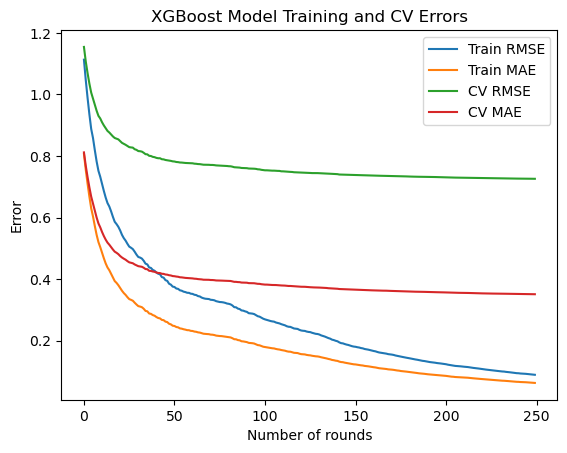

In [35]:
plot_cv_error(model)

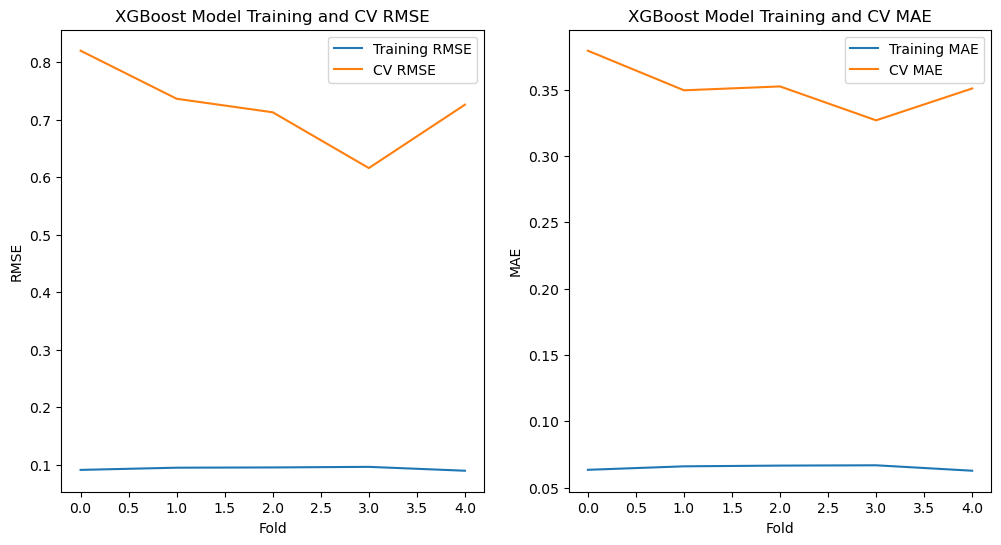

In [36]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [37]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.46997618312110545
MSE:  0.11324485976142724
RMSE:  0.3365187361224145


In [38]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.17873370395303223
MSE:  0.8212662960469678
RMSE:  0.9062374391112783


In [39]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.6576363678560625
MSE:  0.216517340691612
RMSE:  0.46531423865127103


In [40]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [41]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 0.9062
MAE: 0.4554
R2: 0.1787


In [42]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.4653
MAE: 0.2488
R2: 0.6576


In [43]:
df_eu_apply_target

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,target_variable,index,predicted_value
0,EU,AT,AT1,AT11,AT111,-0.6024,0,-0.5787
1,EU,AT,AT1,AT11,AT112,0.0200,1,-0.3157
2,EU,AT,AT1,AT11,AT113,-0.4756,2,-0.4386
3,EU,AT,AT1,AT12,AT121,1.0457,3,-0.1564
4,EU,AT,AT1,AT12,AT122,0.0085,4,-0.0689
...,...,...,...,...,...,...,...,...
1165,EU,SK,SK0,SK02,SK023,-0.4756,1165,-0.0259
1166,EU,SK,SK0,SK03,SK031,-0.3373,1166,0.0045
1167,EU,SK,SK0,SK03,SK032,-0.1990,1167,-0.1803
1168,EU,SK,SK0,SK04,SK041,-0.2797,1168,-0.0897


In [44]:
master_input_train_df

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,gross domestic product_value,live births_value,train_station_value,number of pixels with sport and leisure facilities_value,Traffic_flow_tons_2019,...,number of pixels with transitional woodland-shrub_value,total employment_value,number of pixels with mixed forest_value,total area_value,number of pixels with pastures_value,bus_stations_value,number of pixels with continuous urban fabric_value,airport_stations_value,charging_stations_value,index
0,EU,AT,AT1,AT11,AT111,-0.0730,-0.7251,-0.7243,-0.5951,-0.9606,...,-0.3575,-0.6567,-0.1454,-0.4786,-0.5268,-0.6678,-0.3991,-0.7035,1.5631,0
1,EU,AT,AT1,AT11,AT112,-0.0471,-0.4910,0.2511,-0.2675,-0.4981,...,-0.3425,-0.4315,-0.3342,-0.2967,-0.4569,-0.3494,-0.2439,-0.7035,1.0083,1
2,EU,AT,AT1,AT11,AT113,-0.0604,-0.6237,-0.5849,-0.4091,-0.6582,...,-0.3612,-0.5551,0.0484,-0.3502,-0.4385,-0.4860,-0.2759,-0.3455,1.2936,2
3,EU,AT,AT1,AT12,AT121,-0.0287,-0.2422,1.2730,-0.0357,0.0852,...,-0.1439,-0.2793,0.5664,-0.0359,0.3579,0.8741,-0.1653,0.7283,0.6136,3
4,EU,AT,AT1,AT12,AT122,-0.0257,-0.2736,1.3194,-0.2964,0.1979,...,-0.2990,-0.2748,0.8125,-0.0339,0.0590,0.2852,-0.3262,-0.1666,0.5511,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25735,EU,SK,SK0,SK02,SK023,-0.0934,0.5471,1.5052,-0.2978,-0.0745,...,-0.2831,0.4911,-0.2453,0.4623,-0.4096,0.5619,-0.3482,1.6236,-0.1208,25735
25736,EU,SK,SK0,SK03,SK031,-0.0601,0.8446,1.8768,0.9674,-0.4709,...,0.4410,0.5735,0.9838,0.5398,0.5665,0.3321,-0.3566,1.7195,-0.1279,25736
25737,EU,SK,SK0,SK03,SK032,-0.1840,0.5231,0.8549,0.5827,-0.5206,...,0.1240,0.3089,1.3880,0.9808,0.5026,1.2953,-0.3519,1.4618,-0.1087,25737
25738,EU,SK,SK0,SK04,SK041,-0.1528,1.3811,0.9943,0.6356,0.7447,...,0.2482,0.4313,0.7915,0.9006,0.6014,0.5252,-0.3745,2.4705,-0.1838,25738


# Calling the Model for 2nd Iteration

In [45]:
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population, \
                                            disagg_metric_population_eu \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:111: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [46]:
master_input_train_df

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,gross domestic product_value,live births_value,train_station_value,number of pixels with sport and leisure facilities_value,Traffic_flow_tons_2019,...,number of pixels with transitional woodland-shrub_value,total employment_value,number of pixels with mixed forest_value,total area_value,number of pixels with pastures_value,bus_stations_value,number of pixels with continuous urban fabric_value,airport_stations_value,charging_stations_value,index
0,EU,AT,AT1,AT11,AT111,-0.0730,-0.7251,-0.7243,-0.5951,-0.9606,...,-0.3575,-0.6567,-0.1454,-0.4786,-0.5268,-0.6678,-0.3991,-0.7035,-0.5787,0
1,EU,AT,AT1,AT11,AT112,-0.0471,-0.4910,0.2511,-0.2675,-0.4981,...,-0.3425,-0.4315,-0.3342,-0.2967,-0.4569,-0.3494,-0.2439,-0.7035,-0.3157,1
2,EU,AT,AT1,AT11,AT113,-0.0604,-0.6237,-0.5849,-0.4091,-0.6582,...,-0.3612,-0.5551,0.0484,-0.3502,-0.4385,-0.4860,-0.2759,-0.3455,-0.4386,2
3,EU,AT,AT1,AT12,AT121,-0.0287,-0.2422,1.2730,-0.0357,0.0852,...,-0.1439,-0.2793,0.5664,-0.0359,0.3579,0.8741,-0.1653,0.7283,-0.1564,3
4,EU,AT,AT1,AT12,AT122,-0.0257,-0.2736,1.3194,-0.2964,0.1979,...,-0.2990,-0.2748,0.8125,-0.0339,0.0590,0.2852,-0.3262,-0.1666,-0.0689,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25735,EU,SK,SK0,SK02,SK023,-0.0934,0.5471,1.5052,-0.2978,-0.0745,...,-0.2831,0.4911,-0.2453,0.4623,-0.4096,0.5619,-0.3482,1.6236,-0.0259,25735
25736,EU,SK,SK0,SK03,SK031,-0.0601,0.8446,1.8768,0.9674,-0.4709,...,0.4410,0.5735,0.9838,0.5398,0.5665,0.3321,-0.3566,1.7195,0.0045,25736
25737,EU,SK,SK0,SK03,SK032,-0.1840,0.5231,0.8549,0.5827,-0.5206,...,0.1240,0.3089,1.3880,0.9808,0.5026,1.2953,-0.3519,1.4618,-0.1803,25737
25738,EU,SK,SK0,SK04,SK041,-0.1528,1.3811,0.9943,0.6356,0.7447,...,0.2482,0.4313,0.7915,0.9006,0.6014,0.5252,-0.3745,2.4705,-0.0897,25738


In [47]:
X_train, X_test, y_train, y_test, \
X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [43,
                #  124,
                #  457,
                #  790
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 43
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0896, Mean CV RMSE: 0.7133
Mean Train MAE: 0.0628, Mean CV MAE: 0.3492
Mean Train R2: 0.9939


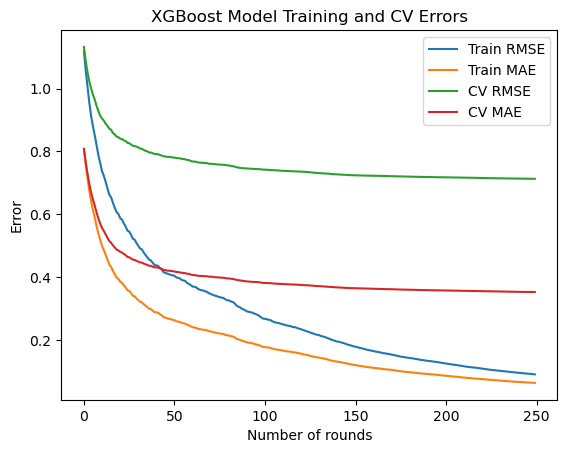

In [48]:
plot_cv_error(model)

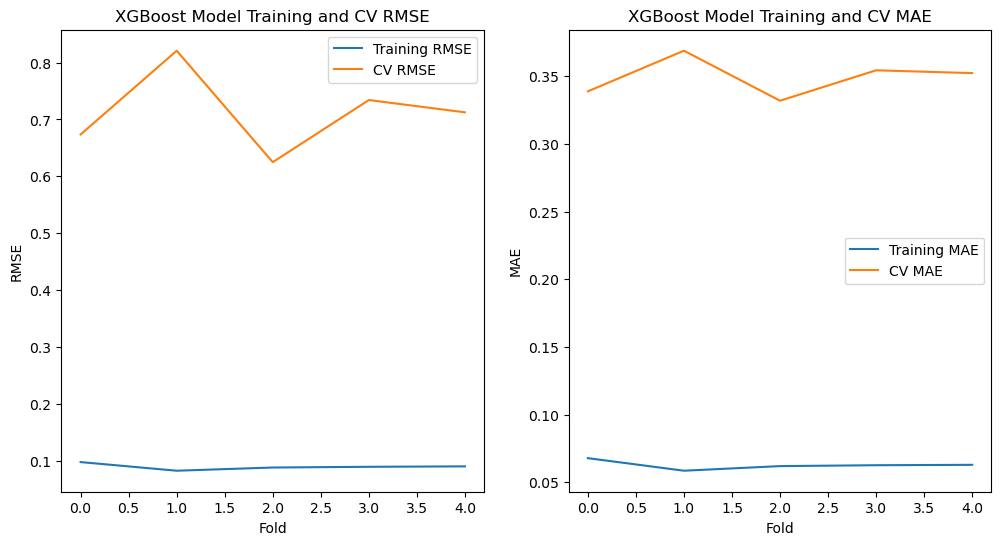

In [49]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [50]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.4190245643964374
MSE:  0.1241311798348724
RMSE:  0.3523225508463408


In [51]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.17247110906769403
MSE:  0.827528890932306
RMSE:  0.9096861496869709


In [52]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.5939848296839636
MSE:  0.2567717967202809
RMSE:  0.5067265502421211


In [53]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [54]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 0.9097
MAE: 0.4699
R2: 0.1725


In [55]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.5067
MAE: 0.2750
R2: 0.5940


In [56]:
df_eu_apply_target

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,target_variable,index,predicted_value
0,EU,AT,AT1,AT11,AT111,-0.6024,0,-0.5748
1,EU,AT,AT1,AT11,AT112,0.0200,1,-0.3315
2,EU,AT,AT1,AT11,AT113,-0.4756,2,-0.4303
3,EU,AT,AT1,AT12,AT121,1.0457,3,-0.1139
4,EU,AT,AT1,AT12,AT122,0.0085,4,-0.0937
...,...,...,...,...,...,...,...,...
1165,EU,SK,SK0,SK02,SK023,-0.4756,1165,-0.0625
1166,EU,SK,SK0,SK03,SK031,-0.3373,1166,0.0265
1167,EU,SK,SK0,SK03,SK032,-0.1990,1167,-0.1507
1168,EU,SK,SK0,SK04,SK041,-0.2797,1168,0.4563


# Calling the Model for 3rd Iteration

In [57]:
print('The variable to disaggregate is: ', agg_var_to_disagg)
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population, \
                                            disagg_metric_population_eu \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:111: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [58]:
X_train, X_test, y_train, y_test, \
X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

In [59]:
# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

In [60]:
X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [61]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [44,
                #  125,
                #  458,
                #  791
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 44
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0918, Mean CV RMSE: 0.6966
Mean Train MAE: 0.0641, Mean CV MAE: 0.3482
Mean Train R2: 0.9936


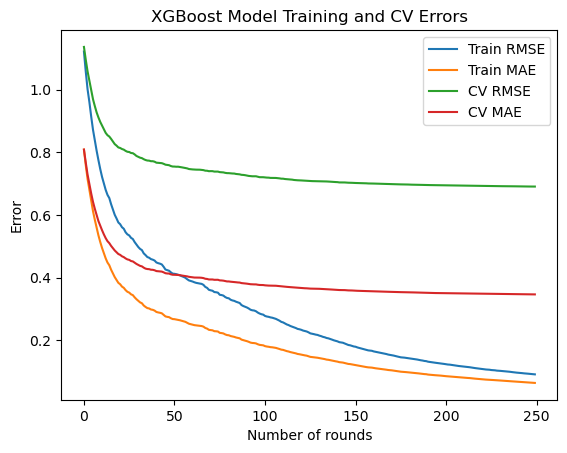

In [62]:
plot_cv_error(model)

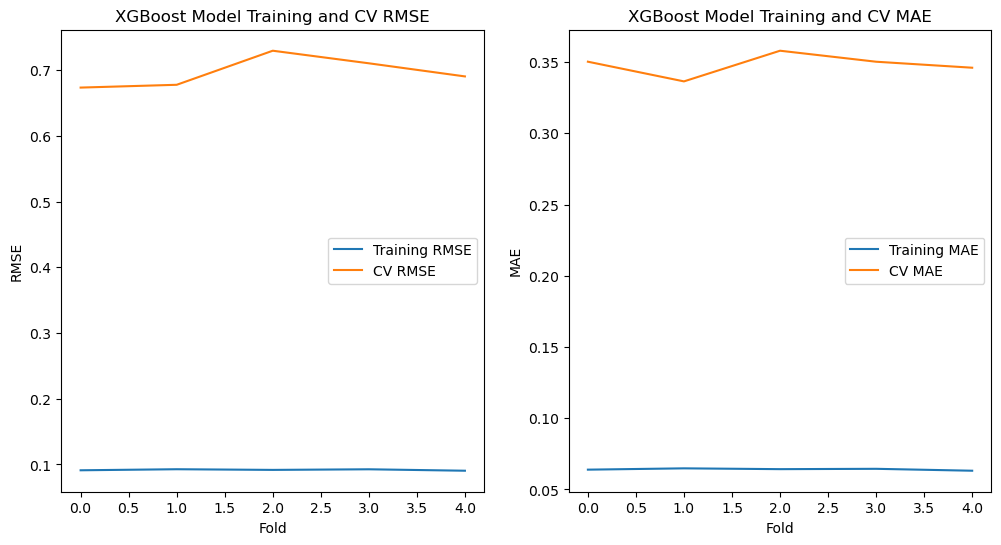

In [63]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [64]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.4131919167078699
MSE:  0.12537738302139934
RMSE:  0.35408668856849074


In [65]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.09343579752351805
MSE:  0.906564202476482
RMSE:  0.952136651157008


In [66]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.641930436106368
MSE:  0.22645007377494986
RMSE:  0.47586770616942464


In [67]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [68]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 0.9521
MAE: 0.4788
R2: 0.0934


In [69]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.4759
MAE: 0.2766
R2: 0.6419


In [70]:
df_eu_apply_target

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,target_variable,index,predicted_value
0,EU,AT,AT1,AT11,AT111,-0.6024,0,-0.5457
1,EU,AT,AT1,AT11,AT112,0.0200,1,-0.2599
2,EU,AT,AT1,AT11,AT113,-0.4756,2,-0.4723
3,EU,AT,AT1,AT12,AT121,1.0457,3,-0.1234
4,EU,AT,AT1,AT12,AT122,0.0085,4,-0.1846
...,...,...,...,...,...,...,...,...
1165,EU,SK,SK0,SK02,SK023,-0.4756,1165,-0.0308
1166,EU,SK,SK0,SK03,SK031,-0.3373,1166,0.0295
1167,EU,SK,SK0,SK03,SK032,-0.1990,1167,-0.2189
1168,EU,SK,SK0,SK04,SK041,-0.2797,1168,-0.0226


# Calling the Model for 4th Iteration

In [71]:
print('The variable to disaggregate is: ', agg_var_to_disagg)
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population, \
                                            disagg_metric_population_eu \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:111: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [72]:
X_train, X_test, y_train, y_test, \
X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

In [73]:
# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

In [74]:
X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [75]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [45,
                #  126,
                #  459,
                #  792
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 45
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0939, Mean CV RMSE: 0.6929
Mean Train MAE: 0.0655, Mean CV MAE: 0.3480
Mean Train R2: 0.9933


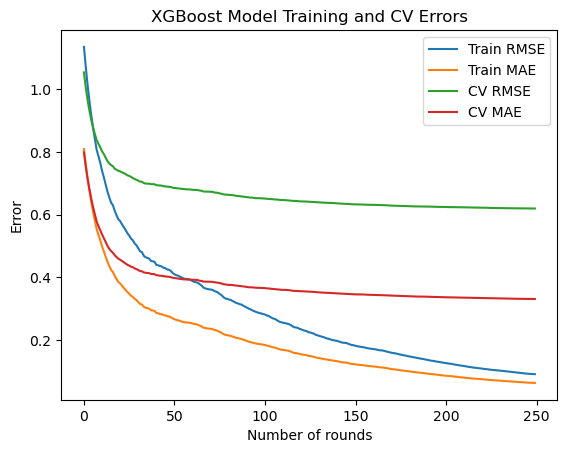

In [76]:
plot_cv_error(model)

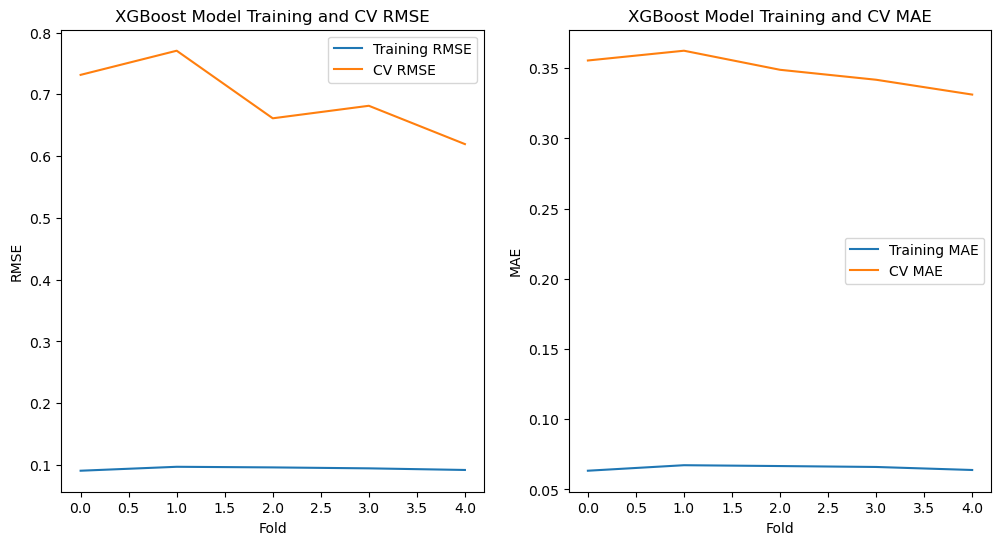

In [77]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [78]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.15831813819948748
MSE:  0.179833700614844
RMSE:  0.4240680377190009


In [79]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.11539132325381185
MSE:  0.8846086767461881
RMSE:  0.9405363771519888


In [80]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.4765848090665302
MSE:  0.3310178260138955
RMSE:  0.5753414864355738


In [81]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [82]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 0.9405
MAE: 0.4898
R2: 0.1154


In [83]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.5753
MAE: 0.3320
R2: 0.4766


In [84]:
df_eu_apply_target

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,target_variable,index,predicted_value
0,EU,AT,AT1,AT11,AT111,-0.6024,0,-0.5955
1,EU,AT,AT1,AT11,AT112,0.0200,1,-0.3184
2,EU,AT,AT1,AT11,AT113,-0.4756,2,-0.4334
3,EU,AT,AT1,AT12,AT121,1.0457,3,-0.1750
4,EU,AT,AT1,AT12,AT122,0.0085,4,-0.0893
...,...,...,...,...,...,...,...,...
1165,EU,SK,SK0,SK02,SK023,-0.4756,1165,-0.0249
1166,EU,SK,SK0,SK03,SK031,-0.3373,1166,0.3426
1167,EU,SK,SK0,SK03,SK032,-0.1990,1167,-0.0958
1168,EU,SK,SK0,SK04,SK041,-0.2797,1168,0.0538


# Calling the Model for 5th Iteration

In [85]:
print('The variable to disaggregate is: ', agg_var_to_disagg)
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population, \
                                            disagg_metric_population_eu \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:111: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [86]:
X_train, X_test, y_train, y_test, \
X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

In [87]:
# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

In [88]:
X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [89]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [46,
                #  127,
                #  460,
                #  793
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 46
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0924, Mean CV RMSE: 0.7021
Mean Train MAE: 0.0647, Mean CV MAE: 0.3487
Mean Train R2: 0.9935


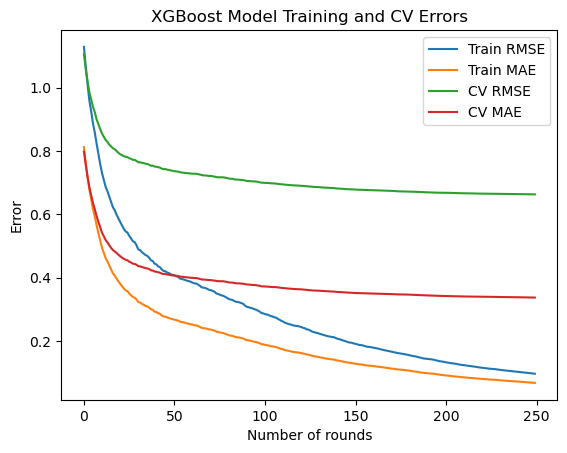

In [90]:
plot_cv_error(model)

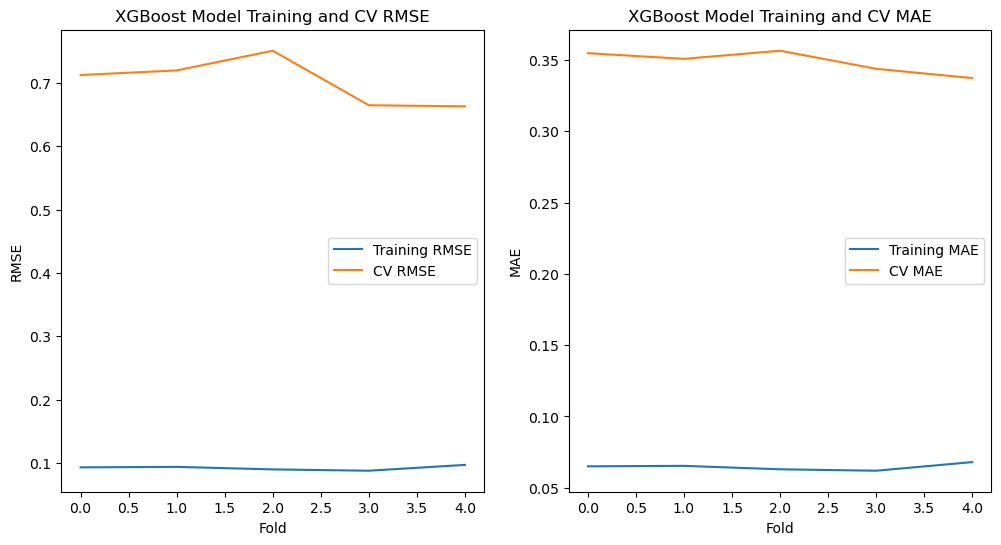

In [91]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [92]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.1697605863985452
MSE:  0.17738890775768498
RMSE:  0.4211756257877288


In [93]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.17544172224703058
MSE:  0.8245582777529694
RMSE:  0.9080519135781662


In [94]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.4149733361823682
MSE:  0.3699821055474287
RMSE:  0.6082615437025661


In [95]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [96]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 0.9081
MAE: 0.4905
R2: 0.1754


In [97]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.6083
MAE: 0.3596
R2: 0.4150


In [98]:
df_eu_apply_target

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,target_variable,index,predicted_value
0,EU,AT,AT1,AT11,AT111,-0.6024,0,-0.5422
1,EU,AT,AT1,AT11,AT112,0.0200,1,-0.3227
2,EU,AT,AT1,AT11,AT113,-0.4756,2,-0.4453
3,EU,AT,AT1,AT12,AT121,1.0457,3,-0.1746
4,EU,AT,AT1,AT12,AT122,0.0085,4,-0.1379
...,...,...,...,...,...,...,...,...
1165,EU,SK,SK0,SK02,SK023,-0.4756,1165,-0.0079
1166,EU,SK,SK0,SK03,SK031,-0.3373,1166,0.0527
1167,EU,SK,SK0,SK03,SK032,-0.1990,1167,-0.2310
1168,EU,SK,SK0,SK04,SK041,-0.2797,1168,-0.0998


# Calling the Model for 6th Iteration

In [99]:
print('The variable to disaggregate is: ', agg_var_to_disagg)
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population, \
                                            disagg_metric_population_eu \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:111: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [100]:
X_train, X_test, y_train, y_test, \
X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

In [101]:
# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

In [102]:
X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [103]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [47,
                #  128,
                #  461,
                #  794
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 47
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0897, Mean CV RMSE: 0.7069
Mean Train MAE: 0.0626, Mean CV MAE: 0.3484
Mean Train R2: 0.9939


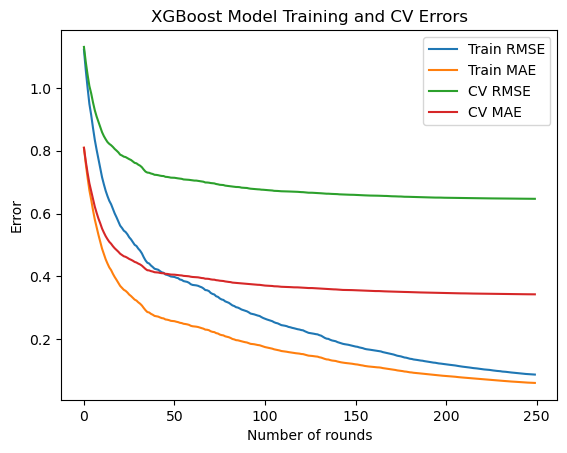

In [104]:
plot_cv_error(model)

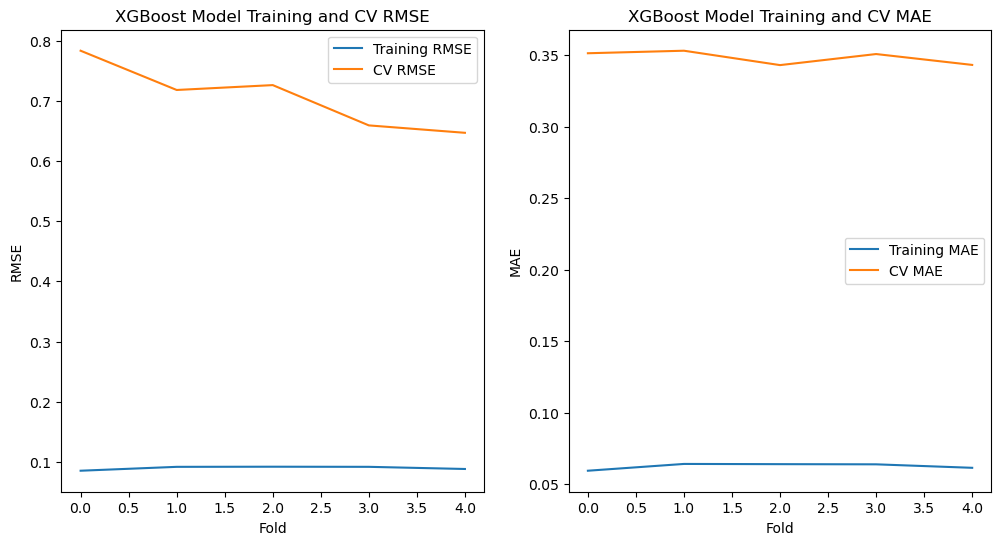

In [105]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [106]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  0.11390480111125101
MSE:  0.18932305179100736
RMSE:  0.43511268861182084


In [107]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.13655305707201293
MSE:  0.8634469429279871
RMSE:  0.9292184581291888


In [108]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.42279211554460805
MSE:  0.365037359213347
RMSE:  0.6041832165935653


In [109]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [110]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 0.9292
MAE: 0.5094
R2: 0.1366


In [111]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.6042
MAE: 0.3938
R2: 0.4228


In [112]:
df_eu_apply_target

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,target_variable,index,predicted_value
0,EU,AT,AT1,AT11,AT111,-0.6024,0,-0.5730
1,EU,AT,AT1,AT11,AT112,0.0200,1,-0.3840
2,EU,AT,AT1,AT11,AT113,-0.4756,2,-0.4571
3,EU,AT,AT1,AT12,AT121,1.0457,3,-0.1630
4,EU,AT,AT1,AT12,AT122,0.0085,4,-0.1570
...,...,...,...,...,...,...,...,...
1165,EU,SK,SK0,SK02,SK023,-0.4756,1165,0.0796
1166,EU,SK,SK0,SK03,SK031,-0.3373,1166,0.0340
1167,EU,SK,SK0,SK03,SK032,-0.1990,1167,-0.1785
1168,EU,SK,SK0,SK04,SK041,-0.2797,1168,0.0181


# Calling the Model for 7th Iteration

In [113]:
print('The variable to disaggregate is: ', agg_var_to_disagg)
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population, \
                                            disagg_metric_population_eu \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:111: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [114]:
X_train, X_test, y_train, y_test, \
X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

In [115]:
# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

In [116]:
X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [117]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 260, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 1,  # Increased L1 regularization
    'reg_lambda': 0.6,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [48,
                #  129,
                #  462,
                #  795
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 48
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.1020, Mean CV RMSE: 0.7173
Mean Train MAE: 0.0707, Mean CV MAE: 0.3507
Mean Train R2: 0.9921


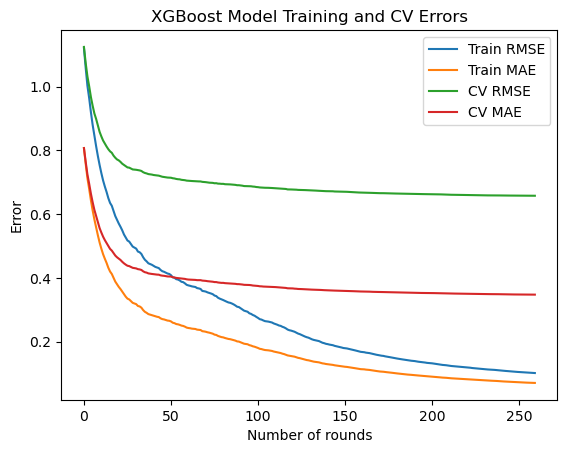

In [118]:
plot_cv_error(model)

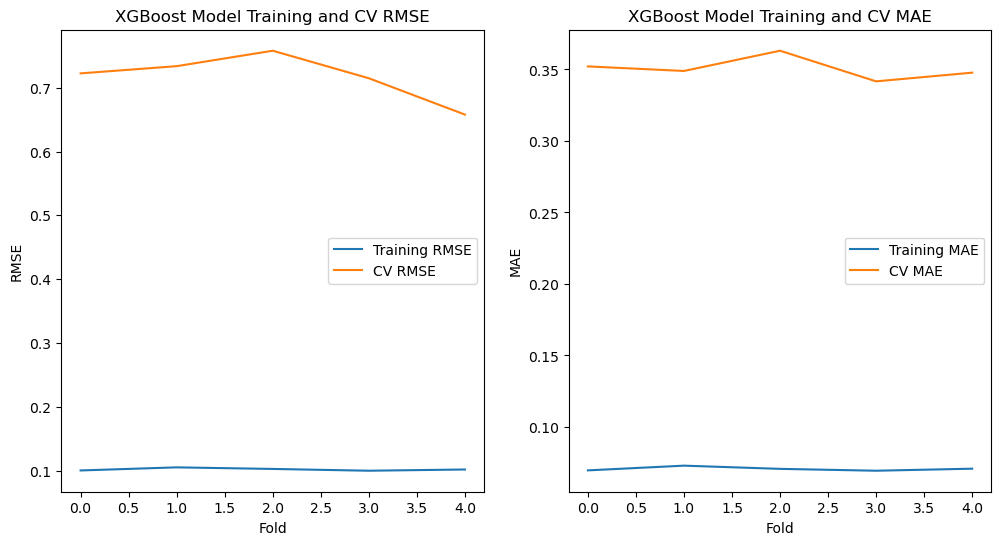

In [119]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [120]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  -0.43172142793980384
MSE:  0.3059015220848458
RMSE:  0.5530836483614805


In [121]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.05576551167130339
MSE:  0.9442344883286966
RMSE:  0.9717172882730329


In [122]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.137686212434889
MSE:  0.5453438116546621
RMSE:  0.7384739749338917


In [123]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [124]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 0.9717
MAE: 0.5411
R2: 0.0558


In [125]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.7385
MAE: 0.4838
R2: 0.1377


In [126]:
df_eu_apply_target

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,target_variable,index,predicted_value
0,EU,AT,AT1,AT11,AT111,-0.6024,0,-0.5726
1,EU,AT,AT1,AT11,AT112,0.0200,1,-0.3235
2,EU,AT,AT1,AT11,AT113,-0.4756,2,-0.4665
3,EU,AT,AT1,AT12,AT121,1.0457,3,0.0048
4,EU,AT,AT1,AT12,AT122,0.0085,4,-0.1092
...,...,...,...,...,...,...,...,...
1165,EU,SK,SK0,SK02,SK023,-0.4756,1165,0.0413
1166,EU,SK,SK0,SK03,SK031,-0.3373,1166,-0.0172
1167,EU,SK,SK0,SK03,SK032,-0.1990,1167,-0.0958
1168,EU,SK,SK0,SK04,SK041,-0.2797,1168,0.4439


# Calling the Model for 8th Iteration

In [127]:
print('The variable to disaggregate is: ', agg_var_to_disagg)
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population, \
                                            disagg_metric_population_eu \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:111: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [128]:
X_train, X_test, y_train, y_test, \
X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

In [129]:
# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

In [130]:
X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [131]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [49,
                #  130,
                #  463,
                #  796
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 49
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0915, Mean CV RMSE: 0.7082
Mean Train MAE: 0.0641, Mean CV MAE: 0.3533
Mean Train R2: 0.9936


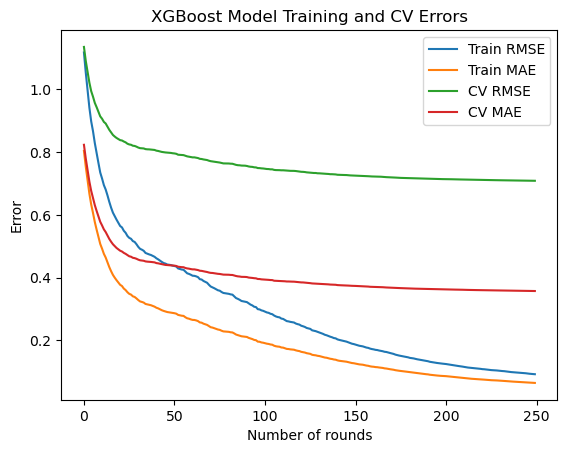

In [132]:
plot_cv_error(model)

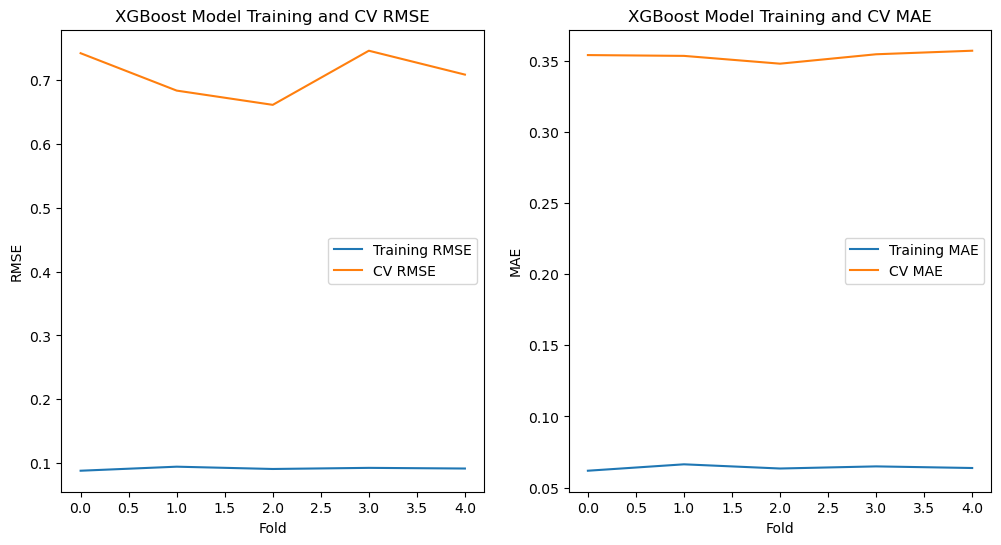

In [133]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [134]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  -0.07642916778016362
MSE:  0.22998979718722243
RMSE:  0.47957251504566273


In [135]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.1187591215981979
MSE:  0.8812408784018021
RMSE:  0.9387443093845108


In [136]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.427605384674008
MSE:  0.36199335531198473
RMSE:  0.6016588363117297


In [137]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [138]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 0.9387
MAE: 0.5142
R2: 0.1188


In [139]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.6017
MAE: 0.4078
R2: 0.4276


In [140]:
df_eu_apply_target

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,target_variable,index,predicted_value
0,EU,AT,AT1,AT11,AT111,-0.6024,0,-0.5668
1,EU,AT,AT1,AT11,AT112,0.0200,1,-0.3413
2,EU,AT,AT1,AT11,AT113,-0.4756,2,-0.4631
3,EU,AT,AT1,AT12,AT121,1.0457,3,-0.0854
4,EU,AT,AT1,AT12,AT122,0.0085,4,-0.1960
...,...,...,...,...,...,...,...,...
1165,EU,SK,SK0,SK02,SK023,-0.4756,1165,-0.0885
1166,EU,SK,SK0,SK03,SK031,-0.3373,1166,0.1445
1167,EU,SK,SK0,SK03,SK032,-0.1990,1167,-0.1431
1168,EU,SK,SK0,SK04,SK041,-0.2797,1168,0.1115


# Calling the Model for 9th Iteration

In [141]:
print('The variable to disaggregate is: ', agg_var_to_disagg)
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population, \
                                            disagg_metric_population_eu \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:111: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [142]:
X_train, X_test, y_train, y_test, \
X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

In [143]:
# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

In [144]:
X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [145]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [50,
                #  131,
                #  464,
                #  797
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 50
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0915, Mean CV RMSE: 0.7208
Mean Train MAE: 0.0642, Mean CV MAE: 0.3527
Mean Train R2: 0.9936


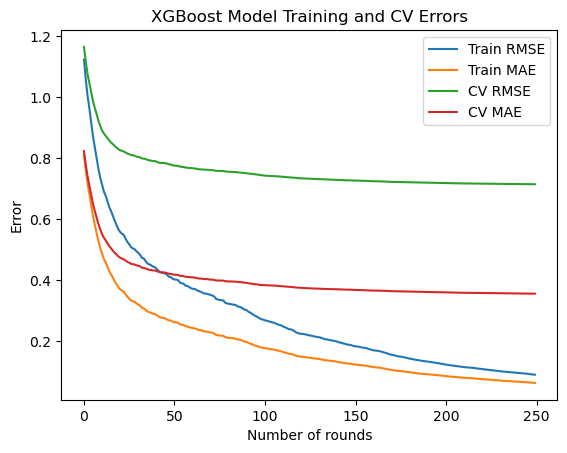

In [146]:
plot_cv_error(model)

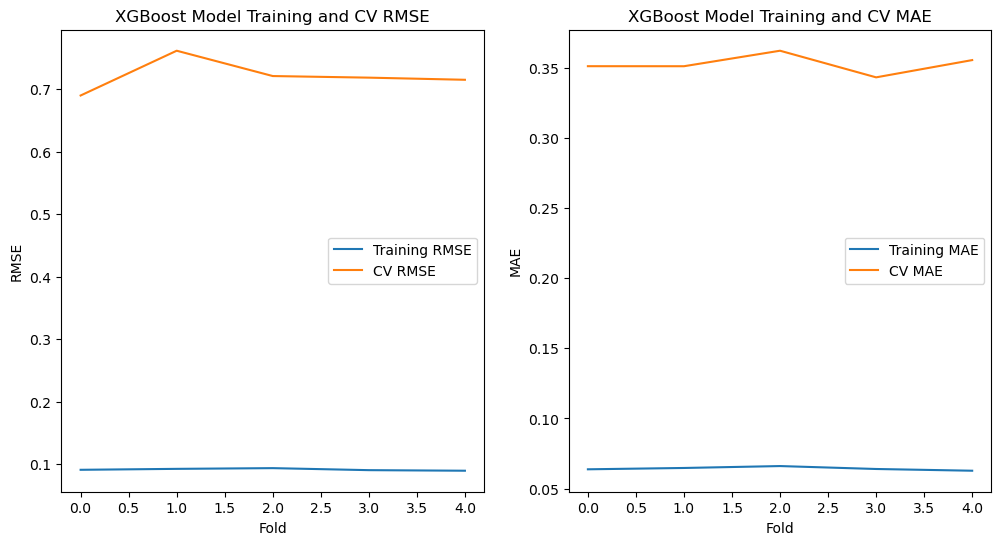

In [147]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [148]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  -0.12413627312827469
MSE:  0.24018289470986623
RMSE:  0.49008457913901576


In [149]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  0.1461734675817643
MSE:  0.8538265324182357
RMSE:  0.9240273439775664


In [150]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  0.35547602832311176
MSE:  0.4076093464880797
RMSE:  0.6384429077749081


In [151]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [152]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 0.9240
MAE: 0.5141
R2: 0.1462


In [153]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.6384
MAE: 0.4279
R2: 0.3555


In [154]:
df_eu_apply_target

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,target_variable,index,predicted_value
0,EU,AT,AT1,AT11,AT111,-0.6024,0,-0.5743
1,EU,AT,AT1,AT11,AT112,0.0200,1,-0.3386
2,EU,AT,AT1,AT11,AT113,-0.4756,2,-0.4652
3,EU,AT,AT1,AT12,AT121,1.0457,3,-0.1282
4,EU,AT,AT1,AT12,AT122,0.0085,4,-0.1379
...,...,...,...,...,...,...,...,...
1165,EU,SK,SK0,SK02,SK023,-0.4756,1165,0.0233
1166,EU,SK,SK0,SK03,SK031,-0.3373,1166,0.0321
1167,EU,SK,SK0,SK03,SK032,-0.1990,1167,-0.0957
1168,EU,SK,SK0,SK04,SK041,-0.2797,1168,0.0630


# Calling the Model for 10th Iteration

In [155]:
print('The variable to disaggregate is: ', agg_var_to_disagg)
master_input_df, \
    master_label_df, \
        master_input_train_df, \
            master_label_train_df, \
                master_input_test_df, \
                    master_label_test_df, \
                        df_apply_eu, \
                            df_apply_region, \
                                df_eu_apply_target, \
                                    df_region_apply_target, \
                                        disagg_metric_population, \
                                            disagg_metric_population_eu \
                = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region, predicted_values=df_eu_apply_target['predicted_value'])

The variable to disaggregate is:  charging_stations_value
The length of all ancilliary features + the aggregated feature is:  23
The length of all ancilliary features is:  22


C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:111: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  master_input_df.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values
C:\Users\rofer\AppData\Local\Temp\ipykernel_14988\1888367668.py:119: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df_apply_eu.loc[:, f"{agg_var_to_disagg}"] = repeated_predicted_values


In [156]:
X_train, X_test, y_train, y_test, \
X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
        y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
    df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
        disagg_metric_population, disagg_metric_population_eu)

In [157]:
# save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

In [158]:
X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [159]:
# Define model parameters
model_params = {
    'objective': 'reg:squarederror',
    'n_estimators': 250, # Increased number of trees
    'max_depth': 10,  # Reduced maximum depth
    'learning_rate': 0.1,  # Reduced learning rate
    'subsample': 1,
    'colsample_bytree': 0.8,
    'reg_alpha': 0.5,  # Increased L1 regularization
    'reg_lambda': 0.5,  # Increased L2 regularization
    'eval_metric': ['rmse', 'mae']
}

# Define a list of random states
random_states = [51,
                #  132,
                #  465,
                #  798
                 ]

# Call the train_xgb_model function with your data and parameters
model, train_losses, cv_losses, train_maes, cv_maes = train_xgb_model(
    X_train, y_train, model_params, random_states=random_states
)

Training with random state: 51
Training fold 1
Training fold 2
Training fold 3
Training fold 4
Training fold 5
Mean Train RMSE: 0.0901, Mean CV RMSE: 0.7058
Mean Train MAE: 0.0628, Mean CV MAE: 0.3485
Mean Train R2: 0.9938


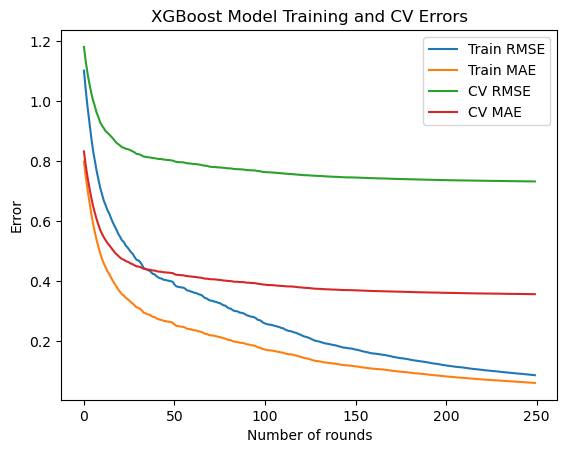

In [160]:
plot_cv_error(model)

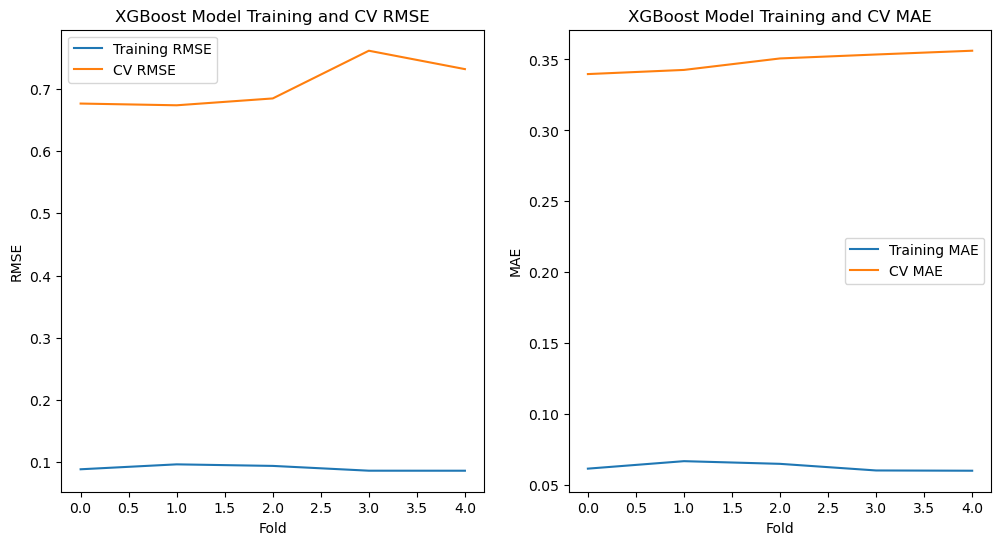

In [161]:
plot_cv_error_by_fold(train_losses, cv_losses, train_maes, cv_maes)

In [162]:
evaluate_model_xgb(model, X_test, y_test)

XGBoost Model Performance
R2 Score:  -0.5655524107732575
MSE:  0.3344958425664316
RMSE:  0.5783561554668815


In [163]:
evaluate_model_xgb(model, X_train_apply, y_train_apply)

XGBoost Model Performance
R2 Score:  -0.029097602166617165
MSE:  1.0290976021666172
RMSE:  1.014444479588024


In [164]:
evaluate_model_xgb(model, X_test_apply, y_test_apply)

XGBoost Model Performance
R2 Score:  -0.016557407974302052
MSE:  0.6428904415362025
RMSE:  0.8018044908431247


In [165]:
predictions_eu, predictions_region = make_predictions(model, X_train_apply, X_test_apply)
pred_apply_eu_df, pred_apply_region_df = create_prediction_dataframes(predictions_eu, predictions_region)
df_eu_apply_target_updated, df_region_apply_target_updated = merge_predictions_with_dataframes(df_eu_apply_target, df_region_apply_target, pred_apply_eu_df, pred_apply_region_df)

In [166]:
print_disaggregation_metrics(y_train_apply, y_predict_pop_eu, df_eu_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 1.7647
MAE: 0.7839
R2: -2.1141

Model-based Disaggregation Metrics:
RMSE: 1.0144
MAE: 0.5700
R2: -0.0291


In [167]:
print_disaggregation_metrics(y_test_apply, y_predict_pop, df_region_apply_target_updated)


Population-based Disaggregation Metrics:
RMSE: 0.6726
MAE: 0.3345
R2: 0.2847

Model-based Disaggregation Metrics:
RMSE: 0.8018
MAE: 0.5584
R2: -0.0166


In [168]:
df_eu_apply_target

,EU_region_code,NUTS0_region_code,NUTS1_region_code,NUTS2_region_code,NUTS3_region_code,target_variable,index,predicted_value
0,EU,AT,AT1,AT11,AT111,-0.6024,0,-0.5762
1,EU,AT,AT1,AT11,AT112,0.0200,1,-0.3109
2,EU,AT,AT1,AT11,AT113,-0.4756,2,-0.4288
3,EU,AT,AT1,AT12,AT121,1.0457,3,-0.1003
4,EU,AT,AT1,AT12,AT122,0.0085,4,-0.1460
...,...,...,...,...,...,...,...,...
1165,EU,SK,SK0,SK02,SK023,-0.4756,1165,0.1127
1166,EU,SK,SK0,SK03,SK031,-0.3373,1166,-0.0225
1167,EU,SK,SK0,SK03,SK032,-0.1990,1167,-0.1634
1168,EU,SK,SK0,SK04,SK041,-0.2797,1168,0.4407


# Hyperparameters Optimization - GridSearchCV

In [169]:
# print('The variable to disaggregate is: ', agg_var_to_disagg)
# master_input_df, \
#     master_label_df, \
#         master_input_train_df, \
#             master_label_train_df, \
#                 master_input_test_df, \
#                     master_label_test_df, \
#                         df_apply_eu, \
#                             df_apply_region, \
#                                 df_eu_apply_target, \
#                                     df_region_apply_target, \
#                                         disagg_metric_population, \
#                                             disagg_metric_population_eu \
#                 = create_master_dataframe_based_on_population_weights(df_inter_eu, df_eu, column_list_eu, agg_var_to_disagg, region)


# X_train, X_test, y_train, y_test, \
# X_train_apply, X_test_apply, y_train_apply, y_test_apply, \
#         y_predict_pop, y_predict_pop_eu = prepare_data(master_input_train_df, master_input_test_df, master_label_train_df, master_label_test_df, \
#     df_apply_eu, df_apply_region, df_eu_apply_target, df_region_apply_target, \
#         disagg_metric_population, disagg_metric_population_eu)

# # save_dataframes(X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop, region, agg_var_to_disagg)
# # X_train, X_test, y_train, y_test, X_train_apply, X_test_apply, y_train_apply, y_test_apply, y_predict_pop = load_dataframes(region, agg_var_to_disagg)

# X_train, y_train, X_test, y_test = shuffle_dataframes(X_train, y_train, X_test, y_test)

In [170]:
# # Initialize the XGBoost model
# model = XGBRegressor(random_state=42)

# # Define the parameter grid to search over
# param_grid = {
#     'n_estimators': [100, 150, 200, 250],
#     'max_depth': [5, 10, 15],
#     'learning_rate': [0.05, 0.1, 0.2],
#     'subsample': [0.6, 0.8, 1.0],
#     'colsample_bytree': [0.6, 0.8, 1.0],
#     'reg_alpha': [0, 0.5, 1, 1.5],  # L1 regularization
#     'reg_lambda': [0, 0.5, 1, 1.5]  # L2 regularization
# }

# # Define custom scorer
# mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)

# # Initialize the GridSearchCV object
# grid_search_mae = GridSearchCV(
#     estimator=model,
#     param_grid=param_grid,
#     scoring='neg_mean_absolute_error',
#     cv=5,
#     n_jobs=-1
# )

# # Fit the GridSearchCV object to the data
# grid_search_mae.fit(X_train, y_train)

# # Print the best hyperparameters and CV score
# print("Best hyperparameters:", grid_search_mae.best_params_)
# print("Best CV score:", -grid_search_mae.best_score_)